# Udacity Capstone Project 
## Facial Emotion classification 
In this notebook I tried some models on FER2013 Dataset which is mainly consists of csv file with 2 colomns


1.   Emotions
2.   Pixels

For the `Emotions` colomn we have 7 different categories 

 0: 'Angry',

 1: 'Disgust',

 2: 'Fear',

 3: 'Happy',

 4: 'Sad',

 5: 'Surprise',

 6: 'Neutral'

 and for the `Pixels` colomn we have a string with pixel values for the image seprated by spaces

 all the Images here are 48*48 in dimensions



In [0]:
import json
import zipfile
import os
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
from IPython.display import display 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.utils import plot_model
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from pylab import rcParams

%matplotlib inline


To get the data from the kaggle page

First you need to get the kaggle.json file for your account (have the key for accessing kaggle)
it has this shape
```
{'username': 'USER1', 'key': 'KEY1'}
```
Then, you need to copy this file to the .kaggle folder in the colab workspace

In [0]:

data = None
with open("/kaggle.json","r") as f:
    data = json.load(f)
print(data)
!mkdir ~/.kaggle/
!cp /kaggle.json ~/.kaggle

In [0]:
#download the Dataset
!pip install kaggle
api_token = data
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
if not os.path.exists("/content/competitions/emotions"):
    os.makedirs("/content/competitions/emotions")
os.chdir('/content/competitions/emotions')
for file in os.listdir():
  if file.split(".")[-1] == "zip":
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

 91% 70.0M/77.3M [00:00<00:00, 92.4MB/s]
100% 77.3M/77.3M [00:00<00:00, 106MB/s] 
 96% 88.0M/92.0M [00:00<00:00, 182MB/s]
100% 92.0M/92.0M [00:00<00:00, 226MB/s]
 78% 15.0M/19.3M [00:00<00:00, 78.4MB/s]
100% 19.3M/19.3M [00:00<00:00, 76.6MB/s]
 98% 95.0M/96.6M [00:00<00:00, 75.5MB/s]
100% 96.6M/96.6M [00:00<00:00, 105MB/s] 
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.19MB/s]


In [0]:
data= pd.read_csv('/content/competitions/emotions/train.csv')
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [0]:
rcParams['figure.figsize'] = 15, 10

checking the number of each class in our dataset

In [0]:
data.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [0]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(emotion_labels)

In [0]:
depth = 1
height = int(sqrt(len(data.pixels[0].split()))) 
width = int(height)

Showing examples of the images we have in our dataset

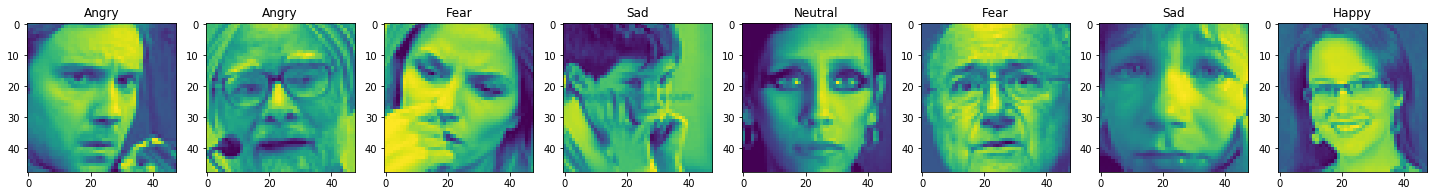

In [0]:
h, w = 10, 10        
nrows, ncols = 1, 8  # array of sub-plots
figsize = [20, 30]     # figure size, inches


# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = np.mat(data.pixels[i]).reshape(height, width) 
    axi.imshow(img)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    axi.set_title(emotion_labels[data.emotion[i]])

plt.tight_layout(True)
plt.show()

## **Preprocessing** 

In [0]:

def gray_to_rgb(im):
  '''
  converts images from single channel images to 3 channels
  '''

  w, h = im.shape
  ret = np.empty((w, h, 3), dtype=np.uint8)
  ret[:, :, 2] =  ret[:, :, 1] =  ret[:, :, 0] =  im
  return ret

def convert_to_image(pixels, mode="save", t="gray"):
  
  '''
  convert the input pixels from the single string row to  48*48 array with real pixel values
  when mode = "save" it keeps the images in flat array shape, otherwise it converts it to 48*48
  when t (for type) = "gray, it keeps the pixels single channel, otherwise it converts it to 3 channels
  '''

  if type(pixels) == str:
      pixels = np.array([int(i) for i in pixels.split()])
  if mode == "show":
    if t == "gray":
      return pixels.reshape(48,48)
    else:
      return gray_to_rgb(pixels.reshape(48,48))
  else:
      return pixels

data["pixels"] = data["pixels"].apply(lambda x : convert_to_image(x, mode="show", t="gray"))
from sklearn.model_selection import train_test_split
#split the data to train, test, and validation
X_train, X_test, y_train, y_test = train_test_split(data["pixels"],  data["emotion"], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train = np.array(list(X_train[:]), dtype=np.float)
X_val = np.array(list(X_val[:]), dtype=np.float)
X_test = np.array(list(X_test[:]), dtype=np.float)

y_train = np.array(list(y_train[:]), dtype=np.float)
y_val = np.array(list(y_val[:]), dtype=np.float)
y_test = np.array(list(y_test[:]), dtype=np.float)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [0]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]


In [0]:
y_train = np_utils.to_categorical(y_train, num_classes) 
# y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes) 
# y_test = test_set.emotion 
y_test = np_utils.to_categorical(y_test, num_classes) 

In [0]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

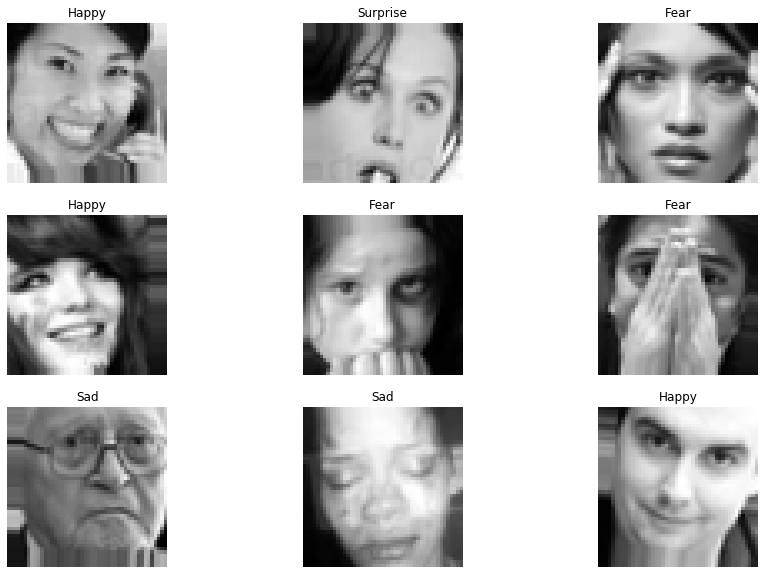

In [0]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        # print(np.where(y_batch[i] == 1)[0][0])
        pyplot.title(emotion_labels[np.where(y_batch[i] == 1)[0][0]])
        pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break 

In [0]:
import keras

In [0]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size) 

In [0]:
conv5_model = Sequential()

conv5_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',name = 'conv1'))
conv5_model.add(BatchNormalization())
conv5_model.add(MaxPooling2D(pool_size=(2, 2)))
conv5_model.add(Dropout(0.25))

conv5_model.add(Conv2D(128, kernel_size=(3, 3),padding="same", activation='relu', name = 'conv2'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv3'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv4'))
conv5_model.add(BatchNormalization())
conv5_model.add(MaxPooling2D(pool_size=(2, 2)))
conv5_model.add(Dropout(0.25))

conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv5'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv6'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv7'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv8'))
conv5_model.add(BatchNormalization())
conv5_model.add(MaxPooling2D(pool_size=(2, 2)))
conv5_model.add(Dropout(0.25))

conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv9'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv10'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv11'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv12'))
conv5_model.add(BatchNormalization())
conv5_model.add(MaxPooling2D(pool_size=(2, 2)))
conv5_model.add(Dropout(0.25))

conv5_model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv13'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv14'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu',  name = 'conv16'))
conv5_model.add(BatchNormalization())
conv5_model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu', name = 'conv17'))
conv5_model.add(BatchNormalization())
conv5_model.add(MaxPooling2D(pool_size=(2, 2)))
conv5_model.add(Dropout(0.25))


conv5_model.add(Flatten())
conv5_model.add(Dense(num_classes, activation='softmax'))
print(conv5_model.summary())














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
conv1 (Conv2D)               (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0   

In [0]:
opt = Adam(lr=0.0001, decay=1e-6)
conv5_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

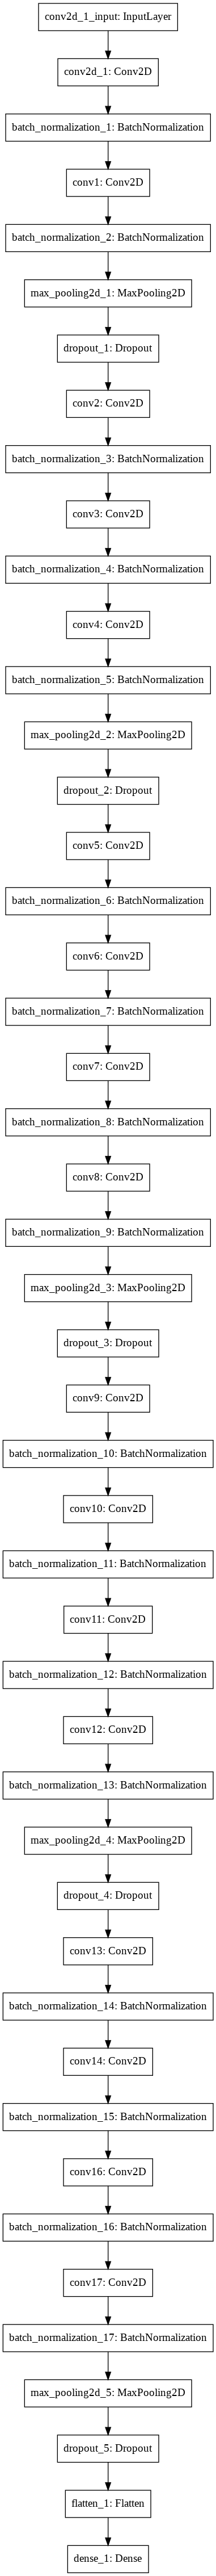

In [0]:
plot_model(conv5_model, to_file='model.png')

In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
num_epochs = 100  
history = conv5_model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 29s - loss: 2.6653 - acc: 0.1881 - val_loss: 1.9727 - val_acc: 0.2558

Epoch 00001: val_loss improved from inf to 1.97273, saving model to weights_min_loss.hdf5
Epoch 2/100
 - 18s - loss: 2.1807 - acc: 0.2103 - val_loss: 1.8364 - val_acc: 0.2612

Epoch 00002: val_loss improved from 1.97273 to 1.83641, saving model to weights_min_loss.hdf5
Epoch 3/100
 - 18s - loss: 2.0937 - acc: 0.2263 - val_loss: 1.8211 - val_acc: 0.2623

Epoch 00003: val_loss improved from 1.83641 to 1.82106, saving model to weights_min_loss.hdf5
Epoch 4/100
 - 18s - loss: 2.0653 - acc: 0.2251 - val_loss: 1.8079 - val_acc: 0.2625

Epoch 00004: val_loss improved from 1.82106 to 1.80789, saving model to weights_min_loss.hdf5
Epoch 5/100
 - 18s - loss: 1.9917 - acc: 0.2337 - val_loss: 1.8617 - val_acc: 0.2627

Epoch 00005: val_loss did not improve from 1.80789
Epoch 6/100
 - 18s - loss: 1.9806 - acc: 0.2400 - v

In [0]:
%matplotlib inline
def visualize_acc(history):

  train_loss=history.history['loss']
  val_loss=history.history['val_loss']
  train_acc=history.history['acc']
  val_acc=history.history['val_acc']

  epochs = range(len(train_acc))

  plt.plot(epochs,train_loss,'r', label='train_loss')
  plt.plot(epochs,val_loss,'b', label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.figure()

  plt.plot(epochs,train_acc,'r', label='train_acc')
  plt.plot(epochs,val_acc,'b', label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.figure()

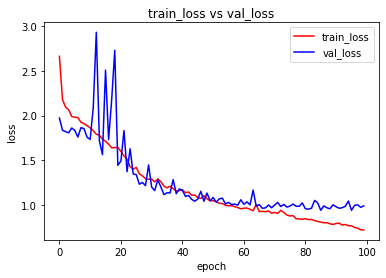

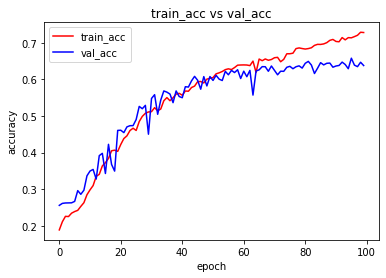

<Figure size 432x288 with 0 Axes>

In [0]:
visualize_acc(history)

In [0]:
loss = conv5_model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Test Loss 1.009787191812355
Test Acc: 0.6450714037128543


In [0]:
loss = conv5_model.evaluate(X_val/255., y_val) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

4594/4594 [==============================] - 2s 432us/step
Test Loss 0.9923541787971244
Test Acc: 0.6377884196518917


In [0]:
y_pred_ = conv5_model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

5742/5742 [==============================] - 3s 453us/step


In [0]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

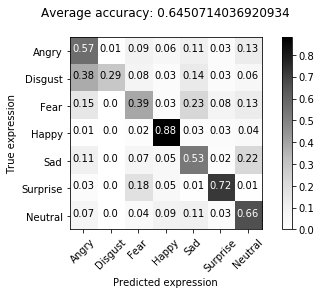

In [0]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

## Trying the pre-trained vgg16 model

### Preprocessing (extra for vgg16 3 channel input)

In [0]:


data["pixels"] = data["pixels"].apply(lambda x : convert_to_image(x, mode="show", t="color"))
from sklearn.model_selection import train_test_split
#split the data to train, test, and validation
X_train, X_test, y_train, y_test = train_test_split(data["pixels"],  data["emotion"], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train = np.array(list(X_train[:]), dtype=np.float)
X_val = np.array(list(X_val[:]), dtype=np.float)
X_test = np.array(list(X_test[:]), dtype=np.float)

y_train = np.array(list(y_train[:]), dtype=np.float)
y_val = np.array(list(y_val[:]), dtype=np.float)
y_test = np.array(list(y_test[:]), dtype=np.float)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 3) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 3)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 3)


In [0]:
X_train.shape

(18373, 48, 48, 3)

In [0]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_val

4594

In [0]:


datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )

batch_size = 64

In [0]:
from keras.applicaations import VGG19
from keras_applications.vgg19 import preprocess_input

X_train = preprocess_input(X_train)
x_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)
datagen.fit(X_train)


y_train = np_utils.to_categorical(y_train, num_classes) 
y_val = np_utils.to_categorical(y_val, num_classes) 
y_test = np_utils.to_categorical(y_test, num_classes)

In [0]:
vgg_model =VGG19(weights='imagenet',
                               include_top=False,
                               input_shape=(48,48,3))
vgg_model.summary()

In [0]:
custom_model = Sequential()
custom_model.add(vgg_model)
custom_model.add(Flatten())
custom_model.add(Dropout(0.5))
custom_model.add(Dense(num_classes,activation='softmax'))


# # Stacking a new simple convolutional network on top of it    
#The Vgg core model
custom_model.layers[0].trainable = False

# the classification layers
custom_model.layers[1].trainable = True
custom_model.layers[2].trainable = True
custom_model.layers[3].trainable = True

# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

In [0]:
for layer in custom_model.layers:
    print(layer.name)
custom_model.layers[0]

vgg19
flatten_2
dropout_6
dense_2


In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss_vgg16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 

In [0]:
num_epochs = 100 
history = custom_model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 24s - loss: 1.8595 - acc: 0.2479 - val_loss: 1.6961 - val_acc: 0.3117

Epoch 00001: val_loss improved from inf to 1.69610, saving model to weights_min_loss_vgg16.hdf5
Epoch 2/100
 - 15s - loss: 1.7325 - acc: 0.3003 - val_loss: 1.6585 - val_acc: 0.3287

Epoch 00002: val_loss improved from 1.69610 to 1.65848, saving model to weights_min_loss_vgg16.hdf5
Epoch 3/100
 - 15s - loss: 1.7090 - acc: 0.3152 - val_loss: 1.6646 - val_acc: 0.3254

Epoch 00003: val_loss did not improve from 1.65848
Epoch 4/100
 - 16s - loss: 1.7014 - acc: 0.3170 - val_loss: 1.6403 - val_acc: 0.3378

Epoch 00004: val_loss improved from 1.65848 to 1.64028, saving model to weights_min_loss_vgg16.hdf5
Epoch 5/100
 - 15s - loss: 1.6989 - acc: 0.3175 - val_loss: 1.6311 - val_acc: 0.3546

Epoch 00005: val_loss improved from 1.64028 to 1.63108, saving model to weights_min_loss_vgg16.hdf5
Epoch 6/100
 - 16s - loss: 

In [0]:
plot_model(custom_model, to_file='model.png')

Using TensorFlow backend.


NameError: ignored

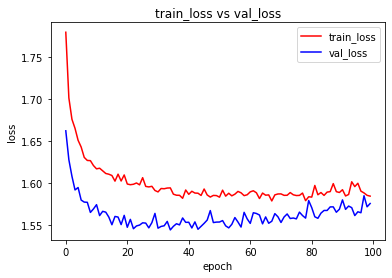

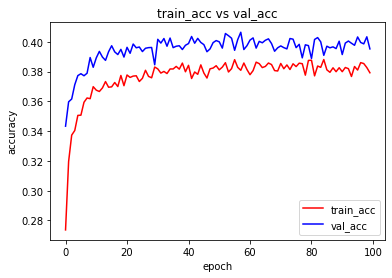

<Figure size 432x288 with 0 Axes>

In [0]:
# visualizing losses and accuracy
#for the Vgg16 model
visualize_acc(history)

#### Using The pretrained vgg16 didn't give me good result, I think the proplem that it needs more training and making some mid layers trainable, I'm planning to test it with more options, but for now let's try a simpler network and see the difference

# trying smaller Conv NN

In [0]:
#let's try smaller Conv model
model_conv = Sequential()

model_conv.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_conv.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

model_conv.add(Flatten())
model_conv.add(Dense(1024, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(7, activation='softmax'))

In [0]:
filepath="weights_min_loss_conv.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Do not forget to compile it
model_conv.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

In [0]:
num_epochs = 100 # we iterate 200 times over the entire training set 
history = model_conv.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)

Epoch 1/100
 - 11s - loss: 1.8260 - acc: 0.2481 - val_loss: 1.7827 - val_acc: 0.2581

Epoch 00001: val_loss improved from inf to 1.78269, saving model to weights_min_loss_conv.hdf5
Epoch 2/100
 - 8s - loss: 1.7490 - acc: 0.2777 - val_loss: 1.7610 - val_acc: 0.2992

Epoch 00002: val_loss improved from 1.78269 to 1.76098, saving model to weights_min_loss_conv.hdf5
Epoch 3/100
 - 9s - loss: 1.6256 - acc: 0.3578 - val_loss: 1.4530 - val_acc: 0.4432

Epoch 00003: val_loss improved from 1.76098 to 1.45300, saving model to weights_min_loss_conv.hdf5
Epoch 4/100
 - 9s - loss: 1.4903 - acc: 0.4231 - val_loss: 1.3358 - val_acc: 0.4891

Epoch 00004: val_loss improved from 1.45300 to 1.33577, saving model to weights_min_loss_conv.hdf5
Epoch 5/100
 - 9s - loss: 1.3888 - acc: 0.4725 - val_loss: 1.2762 - val_acc: 0.5088

Epoch 00005: val_loss improved from 1.33577 to 1.27625, saving model to weights_min_loss_conv.hdf5
Epoch 6/100
 - 8s - loss: 1.3366 - acc: 0.4897 - val_loss: 1.2398 - val_acc: 0.5249

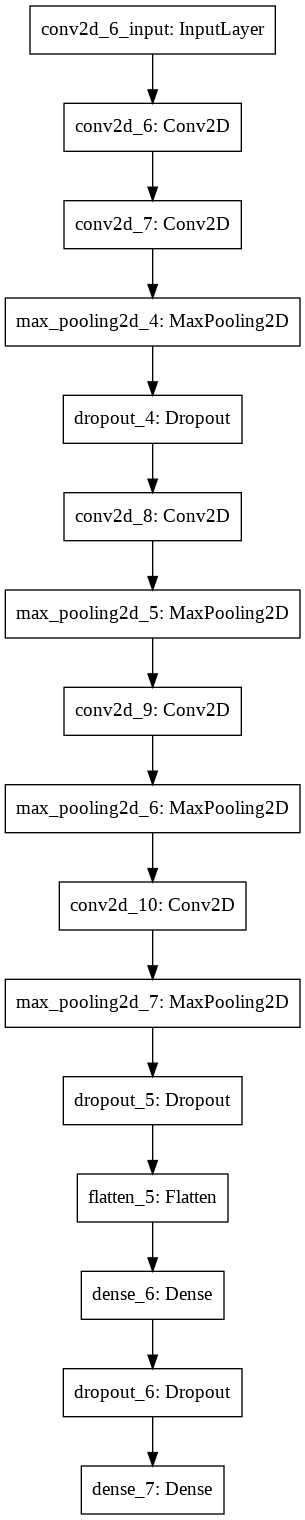

In [0]:
plot_model(model_conv, to_file='model.png')

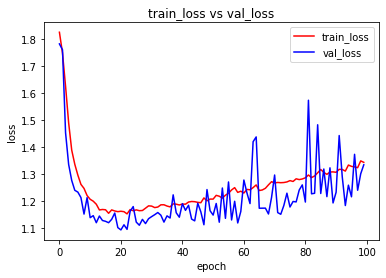

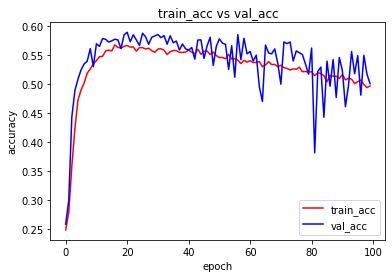

<Figure size 432x288 with 0 Axes>

In [0]:
visualize_acc(history)

In [0]:
loss = model_conv.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Test Loss 1.2908642426138346
Test Acc: 0.5101010101840538


In [0]:
custom_model.save('custom_model.hdf5') 
conv5_model.save('conv5_model')

In [0]:
loss = model_conv.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

5742/5742 [==============================] - 1s 188us/step
Test Loss 1.290864216870275
Test Acc: 0.5101010101632929


In [0]:
loss = model_conv.evaluate(X_val/255., y_val) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

4594/4594 [==============================] - 1s 183us/step
Test Loss 1.2936460631123097
Test Acc: 0.5069656072879388


In [0]:
y_pred_ = model_conv.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

5742/5742 [==============================] - 2s 334us/step


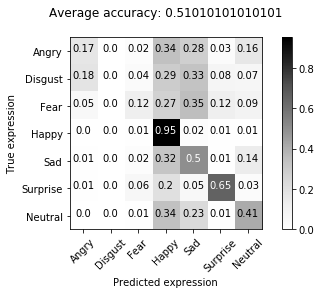

In [0]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')